In [25]:
import pandas as pd
from datetime import datetime
import shapefile
import csv
import numpy as np
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from patsy import dmatrices

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import pickle

### Define helper functions

In [26]:
def make_age(text):
    """Given a year in string format, return current age"""
    return 2015 - datetime.strptime(text, '%Y').year

# for reading csv: converters = {13:make_age}, but NA values mess it up

def explore(x,name):   
    d = {}
    d['length'] = len(x)
    d['unique neighborhoods'] = len(x.n1.value_counts())
    d['unique stations'] = len(x.start_station_id.value_counts())
    d['percent of start stations in Manhattan'] = "{0:.3%}".format(x.b1.value_counts()[0]/len(x))
    d['percent of end stations in Manhattan'] = "{0:.3%}".format(x.b2.value_counts()[0]/len(x))
    d['percent of trips under 1hr'] = "{0:.3%}".format(x.over_hr.value_counts()[0]/len(x))
    d['most popular start station'] = "{0}".format(x.n1.value_counts().reset_index().ix[0].tolist())
    d['least popular start station'] = "{0}".format(x.n1.value_counts().reset_index().ix[36].tolist())
    
    if x.birth_year.isnull().any() == False:
        d['mean birth year'] = "{0:.0f}".format(x.birth_year.mean())
    
    print "\nSummary of {0} dataset".format(name), pd.DataFrame(d.items())

### Read files to dataframes

In [39]:
data = pd.read_csv('201412-citibike-tripdata.csv', nrows = 1000, 
                   parse_dates = [1,2], infer_datetime_format = True) # first n rows of raw citibike data

data_hoods = pd.read_csv('nyc_neighborhoods_copy.csv') # merged database from CartoDB

df = pd.read_csv('citibike_aug.csv') # merged database of neighborhoods and citibike data

docks = data_hoods[['id','docks']] # create sub dataframe of dock capacity per id

In [40]:
# create 'over_hr' column (1 if yes, 0 if no)

df['over_hr'] = df.tripduration.map(lambda x: 1 if x>3600 else 0)


In [41]:
# add docks information to main df

t = pd.merge(df,docks,how='left',left_on='start_station_id',right_on='id')
df = pd.merge(t,docks,how='left',left_on='end_station_id',right_on='id')
#df.drop(['id_x', 'id_y'], axis=1, inplace=True)

### Create subsets

In [42]:
# subscribers
df_1 = df[df['gender']!=0] 

# subscribers with trips under 45min and birth year after 1915
df_2 = df_1[(df_1['over_hr']==0) & (df_1['birth_year']>1915.0)] 

# subscribers with birth year after 1915
df_3 = df_1[df_1['birth_year']>1915.0]


In [43]:
with open('dec_data.pkl','wb') as f:
    pickle.dump(df_3,f)

### Explore the data

In [8]:
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,n1,b1,end_station_id,n2,b2,birth_year,gender,day_start,hour,over_hr,id_x,docks_x,id_y,docks_y
0,0,1257,2014-12-01 00:00:28,2014-12-01 00:21:25,475,Gramercy,Manhattan,521,Chelsea,Manhattan,NaN,0,Monday,0,0,475,21,521,67
1,1,275,2014-12-01 00:00:43,2014-12-01 00:05:18,498,Midtown,Manhattan,546,Midtown,Manhattan,1988,2,Monday,0,0,498,30,546,38
2,2,450,2014-12-01 00:01:22,2014-12-01 00:08:52,444,Flatiron District,Manhattan,434,Chelsea,Manhattan,1983,1,Monday,0,0,444,52,434,27
3,3,1126,2014-12-01 00:02:17,2014-12-01 00:21:03,475,Gramercy,Manhattan,521,Chelsea,Manhattan,NaN,0,Monday,0,0,475,21,521,67
4,4,331,2014-12-01 00:02:21,2014-12-01 00:07:52,519,Murray Hill,Manhattan,527,Kips Bay,Manhattan,1986,2,Monday,0,0,519,61,527,59


In [9]:
explore(df,'full')
explore(df_1,'sub')
explore(df_3,'sub, less than 100 yrs old')
explore(df_2,'sub, trip less than an hour, less than 100 yrs old')


Summary of full dataset                                         0                     1
0              most popular start station    ['Chelsea', 58600]
1                         unique stations                   329
2                                  length                396763
3              percent of trips under 1hr               99.356%
4             least popular start station  ['Columbia St', 197]
5  percent of start stations in Manhattan               93.564%
6                    unique neighborhoods                    37
7    percent of end stations in Manhattan               93.682%

Summary of sub dataset                                         0                     1
0              most popular start station    ['Chelsea', 57049]
1                         unique stations                   329
2                                  length                380309
3              percent of trips under 1hr               99.606%
4             least popular start station  ['Columbia S

### Distribution of birth years

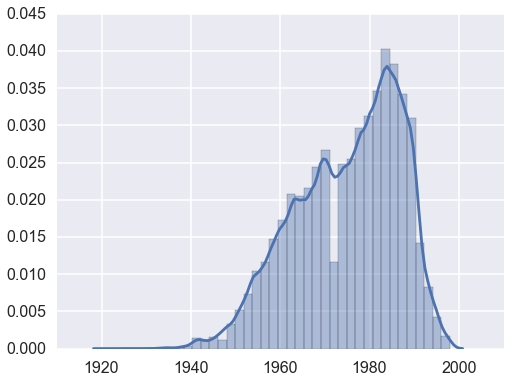

In [10]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_2.birth_year.values,bins=40)

### Distribution of dock capacities over 329 stations

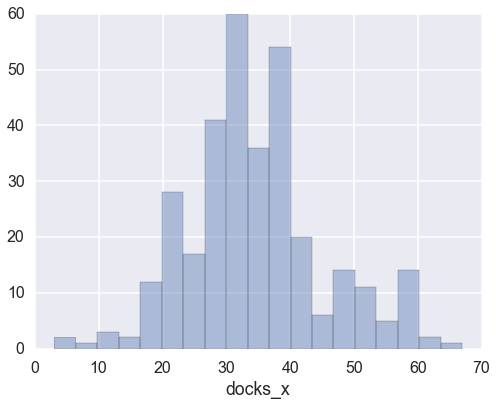

In [11]:
g = df_2.groupby('id_x')

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(g.docks_x.mean(),kde=False)

In [12]:
print "Stations with highest dock capacity"
print data_hoods.sort('docks',ascending=False)[['id','docks','address']].head()
print "\nStations with lowest dock capacity"
print data_hoods.sort('docks',ascending=False)[['id','docks','address']].tail()

Stations with highest dock capacity
      id  docks                            address
170  521     67                    8 Ave & W 31 St
37    83     62      Atlantic Ave & Fort Greene Pl
276  519     61                  Pershing Square N
64   281     59  Grand Army Plaza & Central Park S
205  427     59                           State St

Stations with lowest dock capacity
      id  docks                        address
328  532     10                S 5 Pl & S 4 St
92   524      7                W 43 St & 6 Ave
25   253      7                W 13 St & 5 Ave
211  297      3                E 15 St & 3 Ave
186  321      3  Cadman Plaza E & Red Cross Pl


### Distribution of gender for all rides

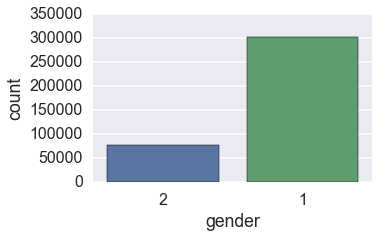

In [13]:
plt.figure(figsize=(5, 3))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.countplot(df_2.gender)

### Number of trips per hour

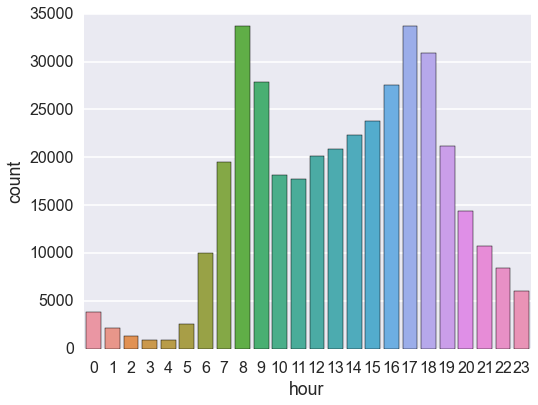

In [14]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.countplot(df_2.hour)

### Mean trip duration per hour

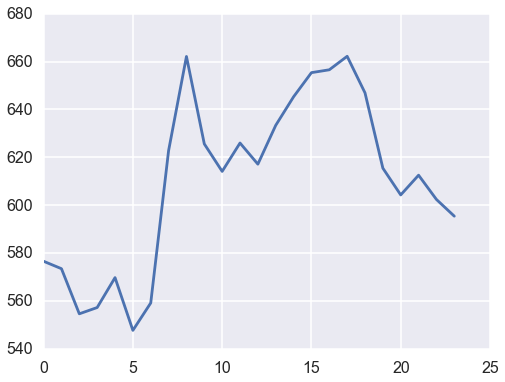

In [15]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
a = df_2.groupby('hour')
plt.plot(a.tripduration.mean())

### Trip duration distribution

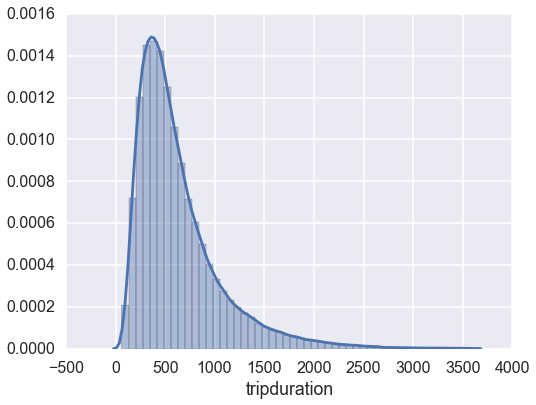

In [16]:
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
sns.distplot(df_2.tripduration)

### Average trip duration from neighborhoods

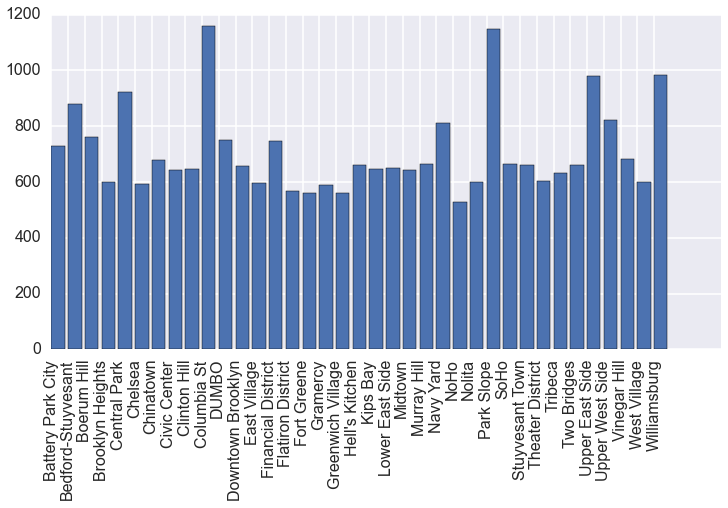

In [17]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
a = df_2.groupby('n1')
names = a.tripduration.mean().reset_index()['n1']
y = a.tripduration.mean().reset_index()['tripduration']
plt.bar(range(len(names)),y)
plt.xticks(range(len(names)), names, rotation='90')
plt.show()

### Average trip duration by borough

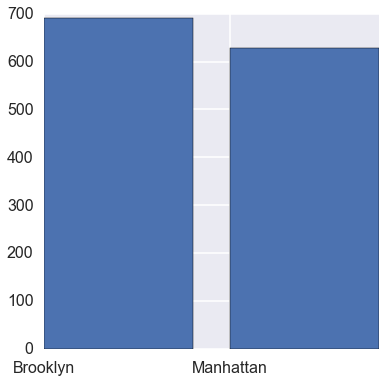

In [18]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.set_context(context="poster")
a = df_2.groupby('b1')
names = a.tripduration.mean().reset_index()['b1']
y = a.tripduration.mean().reset_index()['tripduration']
plt.bar(range(len(names)),y)
plt.xticks(range(len(names)), names)
plt.show()

In [19]:
# list most frequented destination station given start station
g = df_2.groupby('n1')
s = []
for n in df_2['n1'].unique():
    print n,g.n2.value_counts().xs(n).reset_index().ix[0].values
    s.append(g.n2.value_counts().xs(n).reset_index().ix[0].values)

Midtown ['Midtown' 16068]
Flatiron District ['Chelsea' 2262]
Murray Hill ['Midtown' 3037]
NoHo ['East Village' 524]
Two Bridges ['Financial District' 410]
Chelsea ['Chelsea' 18960]
Theater District ['Midtown' 3794]
Greenwich Village ['East Village' 3468]
Civic Center ['Tribeca' 747]
Stuyvesant Town ['East Village' 1405]
Kips Bay ['Midtown' 3167]
East Village ['East Village' 10237]
Hell's Kitchen ['Midtown' 5518]
Clinton Hill ['Fort Greene' 1068]
Williamsburg ['Williamsburg' 790]
Fort Greene ['Fort Greene' 2530]
West Village ['Chelsea' 4207]
Chinatown ['Lower East Side' 1675]
Lower East Side ['Lower East Side' 4344]
SoHo ['West Village' 1334]
Financial District ['Financial District' 2363]
Upper West Side ['Midtown' 969]
Battery Park City ['Battery Park City' 1343]
Gramercy ['Chelsea' 2125]
Nolita ['East Village' 1484]
Brooklyn Heights ['Brooklyn Heights' 1014]
Vinegar Hill ['Fort Greene' 239]
Park Slope ['Boerum Hill' 50]
Central Park ['Midtown' 143]
Tribeca ['Tribeca' 2716]
DUMBO ['Bro

In [20]:
# plot top dest stations (not telling)

plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
sns.set_context(context="poster")

g = pd.DataFrame(s).groupby(0)
d = g.sum().reset_index().sort(1,ascending=False)
n = d[0].values
ct = d[1].values
#plt.bar(range(len(n)),ct,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("dark", 10))
#plt.xticks(range(len(n)), n, rotation='90')

In [21]:
df_2.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,n1,b1,end_station_id,n2,b2,birth_year,gender,day_start,hour,over_hr,id_x,docks_x,id_y,docks_y
1,1,275,2014-12-01 00:00:43,2014-12-01 00:05:18,498,Midtown,Manhattan,546,Midtown,Manhattan,1988,2,Monday,0,0,498,30,546,38
2,2,450,2014-12-01 00:01:22,2014-12-01 00:08:52,444,Flatiron District,Manhattan,434,Chelsea,Manhattan,1983,1,Monday,0,0,444,52,434,27
4,4,331,2014-12-01 00:02:21,2014-12-01 00:07:52,519,Murray Hill,Manhattan,527,Kips Bay,Manhattan,1986,2,Monday,0,0,519,61,527,59
5,5,162,2014-12-01 00:02:37,2014-12-01 00:05:19,229,NoHo,Manhattan,336,Greenwich Village,Manhattan,1973,1,Monday,0,0,229,27,336,34
6,6,155,2014-12-01 00:02:43,2014-12-01 00:05:18,229,NoHo,Manhattan,336,Greenwich Village,Manhattan,1986,1,Monday,0,0,229,27,336,34
